<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import torch
if not os.path.exists('open-images-bus-trucks'):
    %pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

/content/ssd-utils


In [1]:
from  torch_snippets import *
DATA_ROOT = '/content/open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = pd.read_csv(f'{DATA_ROOT}/df.csv')
df = DF_RAW.copy()
df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_class = len(label2target)

In [4]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
import collections
from PIL import Image
from torchvision import transforms
import glob
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

denomalize = transforms.Normalize(
    mean=[-0.485/0.229,-0.456/0.224,-0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  img = normalize(img)
  return img.to(device).float()

class OpenDataset(torch.utils.data.Dataset):
  w,h = 300,300
  def __init__(self,df,image_dir=IMAGE_ROOT):
    self.image_dir =  image_dir
    self.files = glob.glob(self.image_dir+'/*')
    self.df = df
    self.image_infos = df.ImageID.unique()
    logger.info(f'{len(self)} items loaded')

  def __getitem__(self, ix):
    image_id = self.image_infos[ix]
    img_path = find(image_id,self.files)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img.resize((self.w,self.h),
                              resample=Image.BILINEAR))/255.
    data = df[df['ImageID']==image_id]
    labels  = data['LabelName'].values.tolist()
    data = data[['XMin','YMin','XMax','YMax']].values
    data[:,[0,2]] *=self.w
    data[:,[1,3]] *=self.h
    boxes = data.astype(np.uint32).tolist()
    return  img,boxes,labels

  def collate_fn(self,batch):
    images,boxes,labels =  [],[],[]
    for item in batch:
      img,img_boxes,image_labels =  item
      img = preprocess_image(img)
      images.append(img)
      boxes.append(torch.tensor(
          img_boxes).float().to(device)/300.)
      labels.append(torch.tensor(
          [label2target[c] for c  in image_labels]).long().to(device))
    images  =  torch.stack(images).to(device)
    return images,boxes,labels

  def __len__(self):
    return len(self.image_infos)



In [12]:
from sklearn.model_selection import train_test_split
trn_ids,val_ids = train_test_split(df.ImageID.unique(),
                                   test_size=0.1,random_state=99)
trn_df,val_df  = df[df['ImageID'].isin(trn_ids)],\
                df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=4,collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=4,collate_fn=test_ds.collate_fn,drop_last=True)

[06/28/25 16:46:22] INFO     13702 items loaded                                                                                    ]8;id=804759;file:///tmp/ipython-input-5-3179866364.py:27\ipython-input-5-3179866364.py]8;;\:]8;id=737673;file:///tmp/ipython-input-5-3179866364.py:27#__init__:27\__init__:27]8;;\

                    INFO     1523 items loaded                                                                                     ]8;id=50764;file:///tmp/ipython-input-5-3179866364.py:27\ipython-input-5-3179866364.py]8;;\:]8;id=367268;file:///tmp/ipython-input-5-3179866364.py:27#__init__:27\__init__:27]8;;\

In [6]:
def train_batch(inputs,model,criterion,optimizer):
  model.train()
  N = len(train_loader)
  images,boxes,labels = inputs
  _regr,_cls = model(images)
  loss = criterion(_regr,_cls,boxes,labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

@torch.no_grad()
def validate_batch(inputs,model,criterion):
  model.eval()
  images,boxes,labels = inputs
  _regr,_cls = model(images)
  loss = criterion(_regr,_cls,boxes,labels)
  return loss


In [10]:
from model import  SSD300,MultiBoxLoss
from detect  import  *
from torch_snippets.torch_loader import Report
n_epochs = 5
model = SSD300(num_class, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)
log = Report(n_epochs=n_epochs) # Commented out the usage of Report
logs_to_print = 5

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [13]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix,inputs in enumerate(train_loader):
    loss  = train_batch(inputs,model,criterion,optimizer)
    pos = (epoch+(ix+1)/_n)
    log.record(pos,trn_loss=loss.item(),end='\r')

  _n = len(test_loader)
  for ix,inputs in enumerate(test_loader):
      loss = validate_batch(inputs, model, criterion)
      pos = (epoch + (ix+1)/_n)
      log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 5.000  val_loss: 2.024  (4264.13s - 0.00s remaining)

[06/28/25 17:55:56] INFO     Chose `62295e95a112eb98` from input                                                                                        ]8;id=278355;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189\loader.py]8;;\:]8;id=205174;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189#choose:189\choose:189]8;;\

[[38, 32, 225, 167]] ['Truck=1.00']


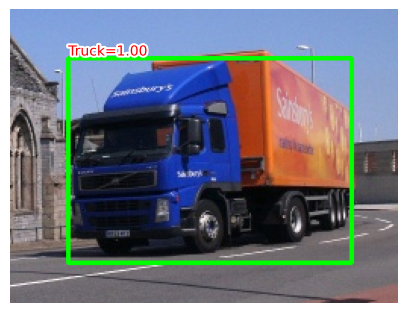

[06/28/25 17:55:57] INFO     Chose `5b1b555a0c7d784a` from input                                                                                        ]8;id=990435;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189\loader.py]8;;\:]8;id=94551;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189#choose:189\choose:189]8;;\

[[59, 9, 205, 96]] ['Bus=1.00']


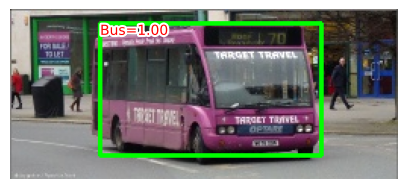

                    INFO     Chose `c9e4d3fd34819686` from input                                                                                        ]8;id=302418;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189\loader.py]8;;\:]8;id=832334;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189#choose:189\choose:189]8;;\

[[0, 0, 256, 192]] ['background=0.00']


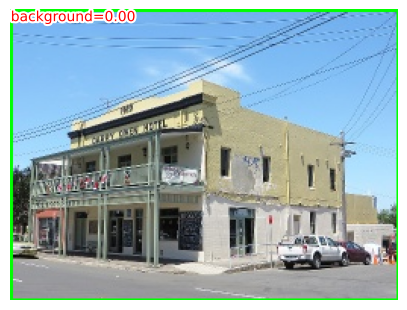

                    INFO     Chose `79812350ac5f88cb` from input                                                                                        ]8;id=324518;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189\loader.py]8;;\:]8;id=983011;file:///usr/local/lib/python3.11/dist-packages/torch_snippets/loader.py:189#choose:189\choose:189]8;;\

[[31, 42, 223, 189]] ['Truck=1.00']


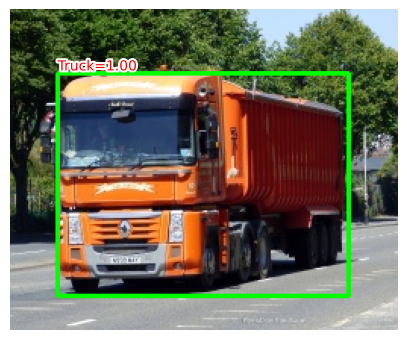

In [17]:
for _ in range(4):
  image_paths = Glob(f'{DATA_ROOT}/images/*')
  image_id = choose(test_ds.image_infos)
  img_path = find(image_id,test_ds.files)
  original_img = Image.open(img_path,mode='r')
  original_img = original_img.convert('RGB')
  bbs,labels,scores  = detect(original_img,model,
                              min_score=0.9,max_overlap=0.5,
                              top_k=200,device=device)
  labels  = [target2label[c.item()] for c in labels]
  label_conf = [f'{l}={s:.2f}'for l,s in zip(labels,scores)]
  print(bbs,label_conf)
  show(original_img,bbs=bbs,texts=label_conf,text_sz=10)